<a href="https://colab.research.google.com/github/Munawerr/Cool-Animation-Transition/blob/main/wan2_2/wan22_Lightx2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WAN2.2 IMAGE TO VIDEO WITH LIGHTX2V LoRA**

- You can use this notebook for basic image to video generation using the new Wan2.2 models. For a notebook that also does video upscale, enhancement, and face correction/swap, visit this link:
https://isinse.gumroad.com/l/wan2point2withLoRA
- To read a guide on using this notebook, see this link: https://penioj.blogspot.com/2025/08/how-to-use-wan22-google-colab-notebooks.html  
- You can use the free T4 GPU to generate a 5-second 480P video (frames=81) with the Q4_K_M GGUF model and with the default settings in about 13 minutes. A 4&1/2-second 720p video (frames=73) can be generated in roughly 35 minutes with the Q4_K_M model on the T4. I recommend that you use higher GPUs for bigger models, longer videos, and faster generations.

- **To use a lora, put its huggingface or civitai download link in the `lora_download_url` textbox, select the `download_lora` checkbox, and if using civitai, input your civitai token before running the code to `Prepare Environment`. Remember to describe the main subject of the image and include the trigger words for the LoRA in the prompt. For the default rotation lora link in lora_3_download_url, the trigger word is r0t4tion 360 degrees rotation. You can get LoRAs from this huggingface repository: https://huggingface.co/collections/Remade-AI/wan21-14b-480p-i2v-loras-67d0e26f08092436b585919b and from civitai: https://civitai.com/models. In civitai, set the `Wan Video` and `LoRA` filters to see the Wan LoRAs.**


In [1]:

# @markdown # 💥1. Prepare Environment
# !pip install --upgrade --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch==2.6.0 torchvision==0.21.0
%cd /content
from IPython.display import clear_output
!pip install -q torchsde einops diffusers accelerate xformers==0.0.29.post2 triton==3.2.0 sageattention==1.0.6
!pip install av spandrel albumentations insightface onnx opencv-python segment_anything ultralytics onnxruntime
!pip install onnxruntime-gpu -y
clear_output()
!git clone --branch ComfyUI_v0.3.47 https://github.com/Isi-dev/ComfyUI
clear_output()
%cd /content/ComfyUI/custom_nodes
!git clone https://github.com/Isi-dev/ComfyUI_GGUF.git
clear_output()
!git clone --branch kjnv1.1.3 https://github.com/Isi-dev/ComfyUI_KJNodes.git
clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_KJNodes
!pip install -r requirements.txt
clear_output()

%cd /content
!git clone https://github.com/Isi-dev/Practical-RIFE
%cd /content/Practical-RIFE
!pip install git+https://github.com/rk-exxec/scikit-video.git@numpy_deprecation
!mkdir -p /content/Practical-RIFE/train_log
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/IFNet_HDv3.py -O /content/Practical-RIFE/train_log/IFNet_HDv3.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/RIFE_HDv3.py -O /content/Practical-RIFE/train_log/RIFE_HDv3.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/refine.py -O /content/Practical-RIFE/train_log/refine.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/flownet.pkl -O /content/Practical-RIFE/train_log/flownet.pkl
clear_output()


%cd /content/ComfyUI
!apt -y install -qq aria2 ffmpeg
clear_output()


import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

from pathlib import Path
import torch
import numpy as np
import cv2
from PIL import Image
import gc
import sys
import random
import imageio
import subprocess
import shutil
from google.colab import files
from IPython.display import display, HTML, Image as IPImage
sys.path.insert(0, '/content/ComfyUI')

from comfy import model_management

from nodes import (
    CheckpointLoaderSimple,
    CLIPLoader,
    CLIPTextEncode,
    VAEDecode,
    VAELoader,
    KSampler,
    KSamplerAdvanced,
    UNETLoader,
    LoadImage,
    SaveImage,
    CLIPVisionLoader,
    CLIPVisionEncode,
    LoraLoaderModelOnly,
    ImageScale
)

from custom_nodes.ComfyUI_GGUF.nodes import UnetLoaderGGUF
from custom_nodes.ComfyUI_KJNodes.nodes.model_optimization_nodes import (
    WanVideoTeaCacheKJ,
    PathchSageAttentionKJ,
    WanVideoNAG,
    SkipLayerGuidanceWanVideo
)

from comfy_extras.nodes_model_advanced import ModelSamplingSD3
from comfy_extras.nodes_images import SaveAnimatedWEBP
from comfy_extras.nodes_video import SaveWEBM
from comfy_extras.nodes_wan import WanImageToVideo
from comfy_extras.nodes_upscale_model import UpscaleModelLoader


def download_with_aria2c(link, folder="/content/ComfyUI/models/loras"):
    import os

    filename = link.split("/")[-1]
    command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {link} -d {folder} -o {filename}"

    print("Executing download command:")
    print(command)

    os.makedirs(folder, exist_ok=True)
    get_ipython().system(command)

    return filename



def download_civitai_model(civitai_link, civitai_token, folder="/content/ComfyUI/models/loras"):
    import os
    import time

    os.makedirs(folder, exist_ok=True)

    try:
        model_id = civitai_link.split("/models/")[1].split("?")[0]
    except IndexError:
        raise ValueError("Invalid Civitai URL format. Please use a link like: https://civitai.com/api/download/models/1523247?...")

    civitai_url = f"https://civitai.com/api/download/models/{model_id}?type=Model&format=SafeTensor"
    if civitai_token:
        civitai_url += f"&token={civitai_token}"

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{timestamp}.safetensors"

    full_path = os.path.join(folder, filename)

    download_command = f"wget --max-redirect=10 --show-progress \"{civitai_url}\" -O \"{full_path}\""
    print("Downloading from Civitai...")

    os.system(download_command)

    local_path = os.path.join(folder, filename)
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"LoRA downloaded successfully: {local_path}")
    else:
        print(f"❌ LoRA download failed or file is empty: {local_path}")

    return filename

def download_lora(link, folder="/content/ComfyUI/models/loras", civitai_token=None):
    """
    Download a model file, automatically detecting if it's a Civitai link or huggingface download.

    Args:
        link: The download URL (either huggingface or Civitai)
        folder: Destination folder for the download
        civitai_token: Optional token for Civitai downloads (required if link is from Civitai)

    Returns:
        The filename of the downloaded model
    """
    if "civitai.com" in link.lower():
        if not civitai_token:
            raise ValueError("Civitai token is required for Civitai downloads")
        return download_civitai_model(link, civitai_token, folder)
    else:
        return download_with_aria2c(link, folder)



def model_download(url: str, dest_dir: str, filename: str = None, silent: bool = True) -> bool:
    """
    Colab-optimized download with aria2c

    Args:
        url: Download URL
        dest_dir: Target directory (will be created if needed)
        filename: Optional output filename (defaults to URL filename)
        silent: If True, suppresses all output (except errors)

    Returns:
        bool: True if successful, False if failed
    """
    try:
        # Create destination directory
        Path(dest_dir).mkdir(parents=True, exist_ok=True)

        # Set filename if not specified
        if filename is None:
            filename = url.split('/')[-1].split('?')[0]  # Remove URL parameters

        # Build command
        cmd = [
            'aria2c',
            '--console-log-level=error',
            '-c', '-x', '16', '-s', '16', '-k', '1M',
            '-d', dest_dir,
            '-o', filename,
            url
        ]

        # Add silent flags if requested
        if silent:
            cmd.extend(['--summary-interval=0', '--quiet'])
            print(f"Downloading {filename}...", end=' ', flush=True)

        # Run download
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)

        if silent:
            print("Done!")
        else:
            print(f"Downloaded {filename} to {dest_dir}")
        return filename

    except subprocess.CalledProcessError as e:
        error = e.stderr.strip() or "Unknown error"
        print(f"\nError downloading {filename}: {error}")
        return False
    except Exception as e:
        print(f"\nError: {str(e)}")
        return False


model_quant = "Q4_K_M" # @param ["Q4_K_M", "Q5_K_M", "Q6_K", "Q8_0"]
# lightx2v_rank = "128" # @param ["32", "64", "128"]
lightx2v_rank = "32"

download_loRA_1 = True # @param {type:"boolean"}
lora_1_download_url = "https://civitai.com/api/download/models/2352688?type=Model&format=SafeTensor"# @param {"type":"string"}

download_loRA_2 = False # @param {type:"boolean"}
lora_2_download_url = "Put your loRA here"# @param {"type":"string"}

download_loRA_3 = False # @param {type:"boolean"}
lora_3_download_url = "https://huggingface.co/Remade-AI/Rotate/resolve/main/rotate_20_epochs.safetensors"# @param {"type":"string"}

token_if_civitai_url = "4bb700391f6e5fba834e6f95251cb586"# @param {"type":"string"}

lora_1 = None
if download_loRA_1:
    lora_1 = download_lora(lora_1_download_url, civitai_token=token_if_civitai_url)
# Validate loRA file extension
valid_extensions = {'.safetensors', '.ckpt', '.pt', '.pth', '.sft'}
if lora_1:
    if not any(lora_1.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_1}")
        lora_1 = None
    else:
        clear_output()
        print("loRA 1 downloaded succesfully!")

lora_2 = None
if download_loRA_2:
    lora_2 = download_lora(lora_2_download_url, civitai_token=token_if_civitai_url)
if lora_2:
    if not any(lora_2.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_2}")
        lora_2 = None
    else:
        clear_output()
        print("loRA 2 downloaded succesfully!")

lora_3 = None
if download_loRA_3:
    lora_3 = download_lora(lora_3_download_url, civitai_token=token_if_civitai_url)
if lora_3:
    if not any(lora_3.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_3}")
        lora_3 = None
    else:
        clear_output()
        print("loRA 3 downloaded succesfully!")


if model_quant == "Q4_K_M":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q4_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
    dit_model2 = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q4_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
elif model_quant == "Q5_K_M":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q5_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
    dit_model2 = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q5_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
elif model_quant == "Q6_K":
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q6_K.gguf", "/content/ComfyUI/models/diffusion_models")
    dit_model2 = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q6_K.gguf", "/content/ComfyUI/models/diffusion_models")
else:
    dit_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q8_0.gguf", "/content/ComfyUI/models/diffusion_models")
    dit_model2 = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q8_0.gguf", "/content/ComfyUI/models/diffusion_models")

clear_output()
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/text_encoders/umt5_xxl_fp8_e4m3fn_scaled.safetensors -d /content/ComfyUI/models/text_encoders -o umt5_xxl_fp8_e4m3fn_scaled.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/vae/wan_2.1_vae.safetensors -d /content/ComfyUI/models/vae -o wan_2.1_vae.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/clip_vision/clip_vision_h.safetensors -d /content/ComfyUI/models/clip_vision -o clip_vision_h.safetensors
clear_output()

if lightx2v_rank == "32":
    lightx2v_lora = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/lightx2v_I2V_14B_480p_cfg_step_distill_rank32_bf16.safetensors", "/content/ComfyUI/models/loras")
    # lightx2v_lora = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/lightx2v_T2V_14B_cfg_step_distill_v2_lora_rank32_bf16.safetensors", "/content/ComfyUI/models/loras")
elif lightx2v_rank == "64":
    lightx2v_lora = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/lightx2v_T2V_14B_cfg_step_distill_v2_lora_rank64_bf16.safetensors", "/content/ComfyUI/models/loras")
else:
    lightx2v_lora = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/lightx2v_T2V_14B_cfg_step_distill_v2_lora_rank128_bf16.safetensors", "/content/ComfyUI/models/loras")

# pusa_lora = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/Wan21_PusaV1_LoRA_14B_rank512_bf16.safetensors", "/content/ComfyUI/models/loras")

walkingToViewersL = model_download("https://huggingface.co/Isi99999/Wan2.1_14B-480p_I2V_LoRAs/resolve/main/walking%20to%20viewers_Wan.safetensors", "/content/ComfyUI/models/loras")
walkingFromBehindL = model_download("https://huggingface.co/Isi99999/Wan2.1_14B-480p_I2V_LoRAs/resolve/main/walking_from_behind.safetensors", "/content/ComfyUI/models/loras")
dancingL = model_download("https://huggingface.co/Isi99999/Wan2.1_14B-480p_I2V_LoRAs/resolve/main/b3ll13-d8nc3r.safetensors", "/content/ComfyUI/models/loras")


def upload_file():
    """Handle file upload (image or video) and return paths."""
    os.makedirs('/content/ComfyUI/input', exist_ok=True)
    uploaded = files.upload()

    paths = []
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'
        shutil.move(src_path, dest_path)
        paths.append(dest_path)
        print(f"File saved to: {dest_path}")

    return paths[0] if paths else None

def upload_fileInt():
    """Handle file upload (image or video) and return paths."""
    os.makedirs('/content/ComfyUI/output', exist_ok=True)
    uploaded = files.upload()

    paths = []
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/output/{filename}'
        shutil.move(src_path, dest_path)
        paths.append(dest_path)
        print(f"File saved to: {dest_path}")

    return paths[0] if paths else None

def extract_frames(video_path, max_frames=None):
    """Extract frames from video and return as a batch tensor."""
    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    frames = []

    while True:
        success, frame = vidcap.read()
        if not success or (max_frames and len(frames) >= max_frames):
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = torch.from_numpy(frame).float() / 255.0
        frames.append(frame)

    if not frames:
        return None, fps

    # Stack frames into a batch tensor: (N, H, W, 3)
    batch = torch.stack(frames, dim=0)
    # print(f"Extracted {len(frames)} frames (shape: {batch.shape})")
    return batch, fps


def select_every_n_frame_tensor(
    frames_tensor: torch.Tensor,
    fps: float,
    n: int,
    skip_first: int = 0,
    max_output_frames: int = 0
):
    if frames_tensor is None or frames_tensor.ndim != 4:
        raise ValueError("frames_tensor must be a 4D tensor of shape (N, H, W, C)")
    if n < 1:
        raise ValueError("n must be >= 1")

    total_frames = frames_tensor.shape[0]

    if skip_first >= total_frames:
        print("No frames available after skipping.")
        return None, 0.0

    frames_to_use = frames_tensor[skip_first:]

    # Select every nth frame
    selected_frames = frames_to_use[::n]

    # Cap output if needed
    if max_output_frames > 0 and selected_frames.shape[0] > max_output_frames:
        selected_frames = selected_frames[:max_output_frames]

    adjusted_fps = fps / n

    if max_output_frames:
        print(f"Frame cap: {max_output_frames} -> Final output: {selected_frames.shape[0]} frames")
    # print(f"Adjusted FPS: {adjusted_fps:.2f}  -> Final output: {selected_frames.shape[0]} frames")

    return selected_frames, adjusted_fps

def swapT(pa, f, s):
    if pa == f:
        pa = s
    return pa



def image_width_height(image):
    if image.ndim == 4:
        _, height, width, _ = image.shape
    elif image.ndim == 3:
        height, width, _ = image.shape
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")
    return width, height

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()

def save_as_mp4(images, filename_prefix, fps, output_dir="/content/ComfyUI/output"):
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.mp4"

    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]

    with imageio.get_writer(output_path, fps=fps) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_mp4U(images, filename_prefix, fps, output_dir="/content/ComfyUI/output"):
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.mp4"

    frames = []
    for i, img in enumerate(images):
        try:

            if isinstance(img, torch.Tensor):
                img = img.cpu().numpy()

            # print(f"Frame {i} initial shape: {img.shape}, dtype: {img.dtype}, max: {img.max()}")  # Debug


            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)


            if len(img.shape) == 4:  # Batch dimension? (N, C, H, W)
                img = img[0]  # Take first image in batch

            if len(img.shape) == 3:
                if img.shape[0] in (1, 3, 4):  # CHW format
                    img = np.transpose(img, (1, 2, 0))
                elif img.shape[2] > 4:  # Too many channels
                    img = img[:, :, :3]
            elif len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)

            # print(f"Frame {i} processed shape: {img.shape}")  # Debug

            # Final validation
            if len(img.shape) != 3 or img.shape[2] not in (1, 3, 4):
                raise ValueError(f"Invalid frame shape after processing: {img.shape}")

            frames.append(img)
        except Exception as e:
            print(f"Error processing frame {i}: {str(e)}")
            raise

    try:
        with imageio.get_writer(output_path, fps=fps) as writer:
            for i, frame in enumerate(frames):
                # print(f"Writing frame {i} with shape: {frame.shape}")  # Debug
                writer.append_data(frame)
    except Exception as e:
        print(f"Error writing video: {str(e)}")
        raise

    return output_path

def save_as_webp(images, filename_prefix, fps, quality=90, lossless=False, method=4, output_dir="/content/ComfyUI/output"):
    """Save images as animated WEBP using imageio."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.webp"


    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]


    kwargs = {
        'fps': int(fps),
        'quality': int(quality),
        'lossless': bool(lossless),
        'method': int(method)
    }

    with imageio.get_writer(
        output_path,
        format='WEBP',
        mode='I',
        **kwargs
    ) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_webm(images, filename_prefix, fps, codec="vp9", quality=32, output_dir="/content/ComfyUI/output"):
    """Save images as WEBM using imageio."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.webm"


    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]


    kwargs = {
        'fps': int(fps),
        'quality': int(quality),
        'codec': str(codec),
        'output_params': ['-crf', str(int(quality))]
    }

    with imageio.get_writer(
        output_path,
        format='FFMPEG',
        mode='I',
        **kwargs
    ) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path

def save_as_image(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)

    Image.fromarray(frame).save(output_path)

    return output_path

def save_as_image2(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if image.ndim == 4:  # Batch dimension
        image = image[0]
    if image.shape[0] == 3:  # CHW to HWC
        image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)

    Image.fromarray(image).save(output_path)
    return output_path


def upload_image():
    """Handle image upload in Colab and store in /content/ComfyUI/input/"""
    from google.colab import files
    import os
    import shutil

    os.makedirs('/content/ComfyUI/input', exist_ok=True)

    uploaded = files.upload()

    # Move each uploaded file to ComfyUI input directory
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'

        shutil.move(src_path, dest_path)
        # print(f"Image saved to: {dest_path}")
        return dest_path

    return None


output_path =""
output_pathU =""


def generate_video(
    image_path: str = None,
    LoRA_Strength: float = 1.00,
    rel_l1_thresh: float = 0.275,
    start_percent: float = 0.1,
    end_percent: float = 1.0,
    positive_prompt: str = "a cute anime girl with massive fennec ears and a big fluffy tail wearing a maid outfit turning around",
    prompt_assist: str = "walking to viewers",
    negative_prompt: str = "色调艳丽，过曝，静态，细节模糊不清，字幕，风格，作品，画作，画面，静止，整体发灰，最差质量，低质量，JPEG压缩残留，丑陋的，残缺的，多余的手指，画得不好的手部，画得不好的脸部，畸形的，毁容的，形态畸形的肢体，手指融合，静止不动的画面，杂乱的背景，三条腿，背景人很多，倒着走",
    width: int = 832,
    height: int = 480,
    seed: int = 82628696717253,
    steps: int = 20,
    cfg_scale: float = 1.0,
    sampler_name: str = "uni_pc",
    scheduler: str = "simple",
    frames: int = 33,
    fps: int = 16,
    output_format: str = "mp4",
    overwrite: bool = False,
    use_lora: bool = True,
    use_lora2: bool = True,
    LoRA_Strength2: float = 1.00,
    use_lora3: bool = True,
    LoRA_Strength3: float = 1.00,
    # use_causvid: bool = False,
    # causvid_Strength: float = 0.80,
    # causvid_steps: int = 4,
    use_lightx2v: bool = False,
    lightx2v_Strength: float = 0.80,
    lightx2v_steps: int = 4,
    use_pusa: bool = False,
    pusa_Strength: float = 1.2,
    pusa_steps: int = 6,
    use_sage_attention: bool = True,
    enable_flow_shift: bool = True,
    shift: float = 8.0,
    enable_flow_shift2: bool = True,
    shift2: float = 8.0,
    end_step1: int = 10,
):

    with torch.inference_mode():

        # Initialize nodes
        unet_loader = UnetLoaderGGUF()
        pathch_sage_attention = PathchSageAttentionKJ()
        wan_video_nag = WanVideoNAG()
        teacache = WanVideoTeaCacheKJ()
        model_sampling = ModelSamplingSD3()
        clip_loader = CLIPLoader()
        clip_encode_positive = CLIPTextEncode()
        clip_encode_negative = CLIPTextEncode()
        vae_loader = VAELoader()
        clip_vision_loader = CLIPVisionLoader()
        clip_vision_encode = CLIPVisionEncode()
        load_image = LoadImage()
        wan_image_to_video = WanImageToVideo()
        ksampler = KSamplerAdvanced()
        vae_decode = VAEDecode()
        save_webp = SaveAnimatedWEBP()
        save_webm = SaveWEBM()
        pAssLora = LoraLoaderModelOnly()
        load_lora = LoraLoaderModelOnly()
        load_lora2 = LoraLoaderModelOnly()
        load_lora3 = LoraLoaderModelOnly()
        # load_causvid_lora = LoraLoaderModelOnly()
        load_lightx2v_lora = LoraLoaderModelOnly()
        load_pusa_lora = LoraLoaderModelOnly()
        image_scaler = ImageScale()

        print("Loading Text_Encoder...")
        clip = clip_loader.load_clip("umt5_xxl_fp8_e4m3fn_scaled.safetensors", "wan", "default")[0]

        positive = clip_encode_positive.encode(clip, positive_prompt)[0]
        negative = clip_encode_negative.encode(clip, negative_prompt)[0]

        del clip
        torch.cuda.empty_cache()
        gc.collect()

        if image_path is None:
            print("Please upload an image file:")
            image_path = upload_image()
        if image_path is None:
            print("No image uploaded!")
        loaded_image = load_image.load_image(image_path)[0]

        width_int, height_int = image_width_height(loaded_image)

        if height == 0:
            height = int(width * height_int / width_int)

        print(f"Image resolution is {width_int}x{height_int}")
        print(f"Scaling image to {width}x{height}...")
        loaded_image = image_scaler.upscale(
            loaded_image,
            "lanczos",
            width,
            height,
            "disabled"
        )[0]

        # clip_vision = clip_vision_loader.load_clip("clip_vision_h.safetensors")[0]
        # clip_vision_output = clip_vision_encode.encode(clip_vision, loaded_image, "none")[0]

        # del clip_vision
        # torch.cuda.empty_cache()
        # gc.collect()

        clip_vision_output = None

        print("Loading VAE...")
        vae = vae_loader.load_vae("wan_2.1_vae.safetensors")[0]

        positive_out, negative_out, latent = wan_image_to_video.encode(
            positive, negative, vae, width, height, frames, 1, loaded_image, clip_vision_output
        )

        usedSteps = steps

        print("Loading high noise Model...")
        model = unet_loader.load_unet(dit_model)[0]

        # model = wan_video_nag.patch(model, negative, 11.0, 0.25, 2.5)[0]

        if enable_flow_shift:
            model = model_sampling.patch(model, shift)[0]

        if prompt_assist != "none":
            if prompt_assist == "walking to viewers":
                print("Loading walking to camera LoRA...")
                model = pAssLora.load_lora_model_only(model, walkingToViewersL, 1)[0]
            if prompt_assist == "walking from behind":
                print("Loading walking from camera LoRA...")
                model = pAssLora.load_lora_model_only(model, walkingFromBehindL, 1)[0]
            if prompt_assist == "b3ll13-d8nc3r":
                print("Loading dancing LoRA...")
                model = pAssLora.load_lora_model_only(model, dancingL, 1)[0]

        if use_lora and lora_1 is not None:
            print("Loading LoRA...")
            model = load_lora.load_lora_model_only(model, lora_1, LoRA_Strength)[0]

        if use_lora2 and lora_2 is not None:
            print("Loading LoRA 2...")
            model = load_lora2.load_lora_model_only(model, lora_2, LoRA_Strength2)[0]

        if use_lora3 and lora_3 is not None:
            print("Loading LoRA 3...")
            model = load_lora3.load_lora_model_only(model, lora_3, LoRA_Strength3)[0]

        # if use_causvid:
        #     print("Loading causvid LoRA...")
        #     model = load_causvid_lora.load_lora_model_only(model, causvid_lora, causvid_Strength)[0]
        #     usedSteps=causvid_steps

        if use_lightx2v:
            print("Loading lightx2v LoRA...")
            model = load_lightx2v_lora.load_lora_model_only(model, lightx2v_lora, lightx2v_Strength)[0]
            usedSteps=lightx2v_steps

        # if use_pusa:
        #     print("Loading pusav1 LoRA...")
        #     model = load_pusa_lora.load_lora_model_only(model, pusa_lora, pusa_Strength)[0]
        #     usedSteps=pusa_steps

        if use_sage_attention:
            model = pathch_sage_attention.patch(model, "auto")[0]

        if rel_l1_thresh > 0:
            print("Setting Teacache...")
            model = teacache.patch_teacache(model, rel_l1_thresh, start_percent, end_percent, "main_device", "14B")[0]

        clear_output()

        print("Generating video with high noise model...")
        sampled = ksampler.sample(
            model=model,
            add_noise="enable",
            noise_seed=seed,
            steps=usedSteps,
            cfg=cfg_scale,
            sampler_name=sampler_name,
            scheduler=scheduler,
            positive=positive_out,
            negative=negative_out,
            latent_image=latent,
            start_at_step=0,
            end_at_step=end_step1,
            return_with_leftover_noise="enable"
        )[0]

        del model
        torch.cuda.empty_cache()
        gc.collect()

        print("Loading low noise Model...")
        model = unet_loader.load_unet(dit_model2)[0]

        # model = wan_video_nag.patch(model, negative, 11.0, 0.25, 2.5)[0]

        if enable_flow_shift2:
            model = model_sampling.patch(model, shift2)[0]

        if prompt_assist != "none":
            if prompt_assist == "walking to viewers":
                print("Loading walking to camera LoRA...")
                model = pAssLora.load_lora_model_only(model, walkingToViewersL, 1)[0]
            if prompt_assist == "walking from behind":
                print("Loading walking from camera LoRA...")
                model = pAssLora.load_lora_model_only(model, walkingFromBehindL, 1)[0]
            if prompt_assist == "b3ll13-d8nc3r":
                print("Loading dancing LoRA...")
                model = pAssLora.load_lora_model_only(model, dancingL, 1)[0]

        if use_lora and lora_1 is not None:
            print("Loading LoRA...")
            model = load_lora.load_lora_model_only(model, lora_1, LoRA_Strength)[0]

        if use_lora2 and lora_2 is not None:
            print("Loading LoRA 2...")
            model = load_lora2.load_lora_model_only(model, lora_2, LoRA_Strength2)[0]

        if use_lora3 and lora_3 is not None:
            print("Loading LoRA 3...")
            model = load_lora3.load_lora_model_only(model, lora_3, LoRA_Strength3)[0]

        # if use_causvid:
        #     print("Loading causvid LoRA...")
        #     model = load_causvid_lora.load_lora_model_only(model, causvid_lora, causvid_Strength)[0]
        #     usedSteps=causvid_steps

        # if use_lightx2v:
        #     print("Loading lightx2v LoRA...")
        #     model = load_lightx2v_lora.load_lora_model_only(model, lightx2v_lora, lightx2v_Strength)[0]
        #     usedSteps=lightx2v_steps

        if use_pusa:
            print("Loading pusav1 LoRA...")
            model = load_pusa_lora.load_lora_model_only(model, lightx2v_lora, pusa_Strength)[0]
            usedSteps=lightx2v_steps

        if use_sage_attention:
            model = pathch_sage_attention.patch(model, "auto")[0]

        if rel_l1_thresh > 0:
            print("Setting Teacache...")
            model = teacache.patch_teacache(model, rel_l1_thresh, start_percent, end_percent, "main_device", "14B")[0]

        clear_output()

        print("Generating video with low noise model...")
        sampled = ksampler.sample(
            model=model,
            add_noise="disable",
            noise_seed=seed,
            steps=usedSteps,
            cfg=cfg_scale,
            sampler_name=sampler_name,
            scheduler=scheduler,
            positive=positive_out,
            negative=negative_out,
            latent_image=sampled,
            start_at_step=end_step1,
            end_at_step=10000,
            return_with_leftover_noise="disable"
        )[0]

        del model
        torch.cuda.empty_cache()
        gc.collect()


        try:
            print("Decoding latents...")
            decoded = vae_decode.decode(vae, sampled)[0]

            del vae
            torch.cuda.empty_cache()
            gc.collect()

            global output_path
            import datetime
            base_name = "ComfyUI"
            if not overwrite:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                base_name += f"_{timestamp}"
            if frames == 1:
                print("Single frame detected - saving as PNG image...")
                output_path = save_as_image(decoded[0], "ComfyUI")
                # print(f"Image saved as PNG: {output_path}")

                display(IPImage(filename=output_path))
            else:
                if output_format.lower() == "webm":
                    print("Saving as WEBM...")
                    output_path = save_as_webm(
                        decoded,
                        base_name,
                        fps=fps,
                        codec="vp9",
                        quality=10
                    )
                elif output_format.lower() == "mp4":
                    print("Saving as MP4...")
                    output_path = save_as_mp4(decoded, base_name, fps)

                    # output_path = save_as_mp4(decoded, "ComfyUI", fps)
                else:
                    raise ValueError(f"Unsupported output format: {output_format}")

                # print(f"Video saved as {output_format.upper()}: {output_path}")

                display_video(output_path)

        except Exception as e:
            print(f"Error during decoding/saving: {str(e)}")
            raise
        finally:
            clear_memory()



def display_video(video_path):
    from IPython.display import HTML
    from base64 import b64encode

    video_data = open(video_path,'rb').read()

    # Determine MIME type based on file extension
    if video_path.lower().endswith('.mp4'):
        mime_type = "video/mp4"
    elif video_path.lower().endswith('.webm'):
        mime_type = "video/webm"
    elif video_path.lower().endswith('.webp'):
        mime_type = "image/webp"
    else:
        mime_type = "video/mp4"  # default

    data_url = f"data:{mime_type};base64," + b64encode(video_data).decode()

    display(HTML(f"""
    <video width=512 controls autoplay loop>
        <source src="{data_url}" type="{mime_type}">
    </video>
    """))

clear_output()

print("✅ Environment Setup Complete!")


# @markdown ---


✅ Environment Setup Complete!


Saving dsfgfdgdsfgf.png to dsfgfdgdsfgf.png


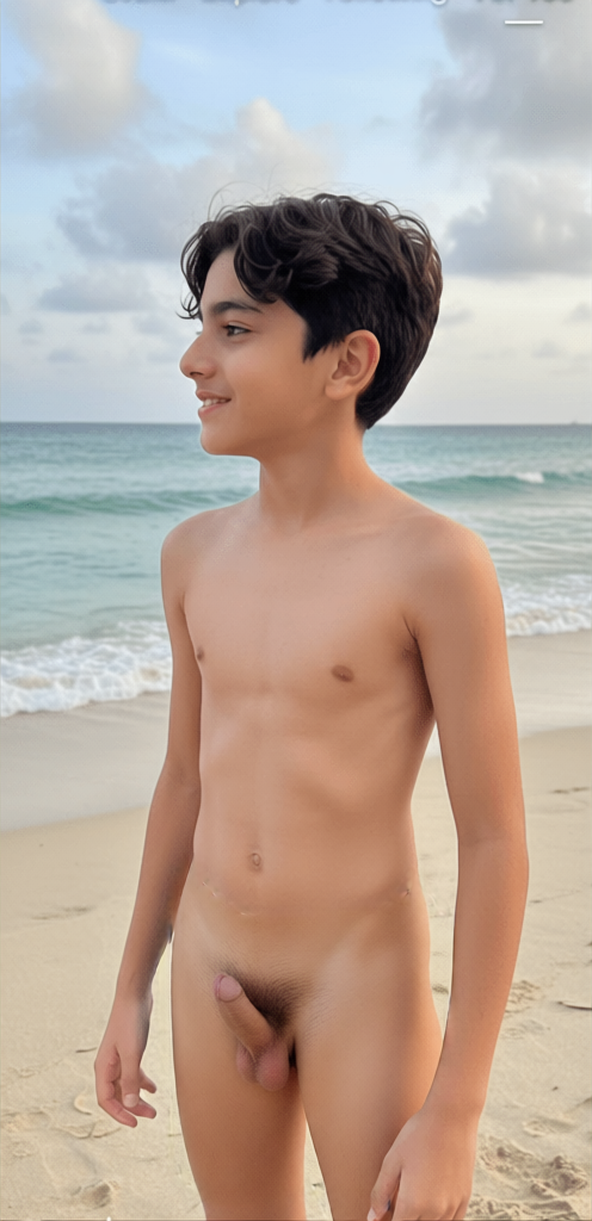

In [25]:

# @markdown # 💥2. Upload Image
file_uploaded = upload_image()
display_upload = True # @param {type:"boolean"}
if display_upload:
    if file_uploaded.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded))
    else:
        print("Image format cannnot be displayed.")
# @markdown ---

In [30]:

# @markdown # 💥3. Generate Video
import time
start_time = time.time()
# @markdown ### Video Settings
positive_prompt = "ARMPIT, 2 naked young black boys with their penis fully erect grope the boy, the short young boy from left side pulls the boy's arm and shows his armpit and starts rubbing it with his fingers. The other boy wraps his arm around the boys chest and touches his exposed armpit with his fingers. The boy being grouped, screams and cry in pain " # @param {"type":"string"}
prompt_assist = "none" # @param ["none","walking to camera", "walking from camera", "swaying"]
prompt_assist = swapT(prompt_assist, "walking to camera", "walking to viewers")
prompt_assist = swapT(prompt_assist, "walking from camera", "walking from behind")
prompt_assist = swapT(prompt_assist, "swaying", "b3ll13-d8nc3r")
positive_prompt = f"{positive_prompt} {prompt_assist}." if prompt_assist != "none" else positive_prompt
# positive_prompt = f"{positive_prompt} Turn this image into {prompt_assist} style." if prompt_assist != "none" else positive_prompt

negative_prompt = "Vibrant colors, overexposed, static, blurry details, subtitles, style, artwork, painting, image, still, overall grayish, worst quality, low quality, JPEG compression residue, ugly, incomplete, extra fingers, poorly drawn hands, poorly drawn faces, deformed, disfigured, distorted limbs, fingers fused together, static image, cluttered background, three legs, many people in the background, walking backwards. armpit hair, underarm hair, pubic hair, red marks on skin, pink marks on skin, hair on armpits" # @param {"type":"string"}
width = 296 # @param {"type":"number"}
height = 611 # @param {"type":"number"}
seed = 0 # @param {"type":"integer"}
high_noise_steps = 3 # @param {"type":"integer", "min":1, "max":25}
steps = 6 # @param {"type":"integer", "min":1, "max":50}
cfg_scale = 1 # @param {"type":"number", "min":1, "max":20}
sampler_name = "euler" # @param ["uni_pc", "uni_pc_bh2", "ddim","euler", "euler_cfg_pp", "euler_ancestral", "euler_ancestral_cfg_pp", "heun", "heunpp2","dpm_2", "dpm_2_ancestral","lms", "dpm_fast", "dpm_adaptive", "dpmpp_2s_ancestral", "dpmpp_2s_ancestral_cfg_pp", "dpmpp_sde", "dpmpp_sde_gpu","dpmpp_2m", "dpmpp_2m_cfg_pp", "dpmpp_2m_sde", "dpmpp_2m_sde_gpu", "dpmpp_3m_sde", "dpmpp_3m_sde_gpu", "ddpm", "lcm","ipndm", "ipndm_v", "deis", "res_multistep", "res_multistep_cfg_pp", "res_multistep_ancestral", "res_multistep_ancestral_cfg_pp","gradient_estimation", "er_sde", "seeds_2", "seeds_3"]
scheduler = "simple" # @param ["simple","normal","karras","exponential","sgm_uniform","ddim_uniform","beta","linear_quadratic","kl_optimal"]
frames = 65 # @param {"type":"integer", "min":1, "max":120}
# fps = 16 # @param {"type":"integer", "min":1, "max":60}
fps = 16
# output_format = "mp4" # @param ["mp4", "webm"]
output_format = "mp4"
overwrite_previous_video = True # @param {type:"boolean"}

# @markdown ### Model Configuration
use_sage_attention = True # @param {type:"boolean"}
# use_sage_attention = True
use_flow_shift = True # @param {type:"boolean"}
flow_shift = 8 # @param {"type":"slider","min":0.0,"max":100.0,"step":0.01}
flow_shift2 = 8 # @param {"type":"slider","min":0.0,"max":100.0,"step":0.01}


# @markdown ### Wan2.1 Based Models LoRA Configuration
# use_causvid = False # @param {type:"boolean"}
# causvid_Strength = 0.8 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
# causvid_steps = 4 # @param {"type":"integer", "min":1, "max":20}
use_lightx2v = True # @param {type:"boolean"}
lightx2v_Strength = 3 # @param {"type":"slider","min":-10,"max":10,"step":0.01}
# lightx2v_steps = 4 # @param {"type":"integer", "min":1, "max":20}
use_lightx2v2 = True # @param {type:"boolean"}
lightx2v2_Strength = 1.5 # @param {"type":"slider","min":-10,"max":10,"step":0.01}
# pusav1_steps = 6 # @param {"type":"integer", "min":1, "max":20}


# @markdown ### LoRA Configuration
use_lora = True # @param {type:"boolean"}
LoRA_Strength = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
use_lora2 = False # @param {type:"boolean"}
LoRA_Strength2 = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
use_lora3 = False # @param {type:"boolean"}
LoRA_Strength3 = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}

# @markdown ### Teacache Settings
rel_l1_thresh = 0 # @param {"type":"slider","min":0.0,"max":10,"step":0.001}
start_percent = 0.2 # @param {"type":"slider","min":0.0,"max":1.0,"step":0.01}
end_percent = 1.0 # @param {"type":"slider","min":0.0,"max":1.0,"step":0.01}

# @markdown ---

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

# with torch.inference_mode():
generate_video(
    image_path=file_uploaded,
    LoRA_Strength=LoRA_Strength,
    rel_l1_thresh=rel_l1_thresh,
    start_percent=start_percent,
    end_percent = end_percent,
    positive_prompt=positive_prompt,
    prompt_assist=prompt_assist,
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    seed=seed,
    steps=steps,
    cfg_scale=cfg_scale,
    sampler_name=sampler_name,
    scheduler=scheduler,
    frames=frames,
    fps=fps,
    output_format=output_format,
    overwrite=overwrite_previous_video,
    use_lora = use_lora,
    use_lora2=use_lora2,
    LoRA_Strength2=LoRA_Strength2,
    use_lora3=use_lora3,
    LoRA_Strength3=LoRA_Strength3,
    # use_causvid=use_causvid,
    # causvid_Strength=causvid_Strength,
    # causvid_steps=causvid_steps,
    use_lightx2v=use_lightx2v,
    lightx2v_Strength=lightx2v_Strength,
    lightx2v_steps=steps,
    use_pusa=use_lightx2v2,
    pusa_Strength=lightx2v2_Strength,
    pusa_steps=steps,
    use_sage_attention = use_sage_attention,
    enable_flow_shift = use_flow_shift,
    shift = flow_shift,
    enable_flow_shift2 = use_flow_shift,
    shift2 = flow_shift2,
    end_step1 = high_noise_steps
)

end_time = time.time()
duration = end_time - start_time
mins, secs = divmod(duration, 60)
print(f"Seed: {seed}")
# print(f"prompt: {positive_prompt}")
print(f"✅ Generation completed in {int(mins)} min {secs:.2f} sec")

clear_memory()

Generating video with low noise model...
Patching comfy attention to use sageattn


  0%|          | 0/3 [00:00<?, ?it/s]

Restoring initial comfy attention
Decoding latents...


Saving as MP4...


Seed: 2732506602
✅ Generation completed in 4 min 45.46 sec


In [ ]:

# @markdown # 💥4. Apply Frame Interpolation
interpolate_optional_video=False # @param {type:"boolean"}

if interpolate_optional_video:
    try:
        output_path = oIoutput_path
    except NameError:
        pass


import glob
from IPython.display import Video as outVid
import time
start_time = time.time()

FRAME_MULTIPLIER = 2 # @param {"type":"number"}
vid_fps = 30 # @param {"type":"number"}
crf_value = 17 # @param {"type":"slider","min":0,"max":51,"step":1}

print(f"Converting video to {vid_fps} fps...")

%cd /content/Practical-RIFE

# Suppress ALSA errors
os.environ["XDG_RUNTIME_DIR"] = "/tmp"
os.environ["SDL_AUDIODRIVER"] = "dummy"

# Disable warnings from ffmpeg about missing audio
os.environ["PYGAME_HIDE_SUPPORT_PROMPT"] = "1"
os.environ["FFMPEG_LOGLEVEL"] = "quiet"

!python3 inference_video.py --multi={FRAME_MULTIPLIER} --fps={vid_fps} --video={output_path} --scale={1}
video_folder = "/content/ComfyUI/output/"

# Find the latest MP4 file
video_files = glob.glob(os.path.join(video_folder, "*.mp4"))

if video_files:
    latest_video = max(video_files, key=os.path.getctime)
    # !ffmpeg -i "{latest_video}" -vcodec libx264 -crf 18 -preset fast output_converted.mp4 -loglevel error -y
    !ffmpeg -i "{latest_video}" -vcodec libx264 -crf {crf_value} -preset fast output_converted.mp4 -loglevel error -y

    print(f"Displaying video: {latest_video}")
    # display(outVid("output_converted.mp4", embed=True))
    display_video("output_converted.mp4")
    # displayVid(outVid(latest_video, embed=True))
else:
    print("❌ No video found in output/")

del video_files

end_time = time.time()
duration = end_time - start_time
mins, secs = divmod(duration, 60)
print(f"✅ Frame Interpolation completed in {int(mins)} min {secs:.2f} sec")

clear_memory()

%cd /content/ComfyUI

# @markdown ---